In [1]:
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
Tot = np.load('3fl_Wall.npy')

In [3]:
print(Tot.shape)

(2839392, 8)


In [4]:
Full = max(Tot[:,3])
FullE = Tot[Tot[:,3]==Full] #Creates array of only full energy deposition
Conc = Tot[(Tot[:,3]<Full) & (Tot[:,6]>0)] #Creates array of less than full energy deposition - Concrete Scattered
Asph = Tot[(Tot[:,3]<Full) & (Tot[:,6]<=0)] #Creates array of less than full energy deposition - Asphault Scattered
print(Full)
print(FullE.shape)
print(Conc.shape)
print(Asph.shape)

1332.492
(813355, 8)
(1997037, 8)
(29000, 8)


In [5]:
#Confirms constant r of 1000 cm for all datapoints 
r = np.sqrt(Tot[:,0]**2+Tot[:,1]**2)
print(r)

[ 492.13742  419.46536 1000.      ...  573.5389   180.87846 1000.     ]


In [6]:
xedges = np.arange(-180.0, 180.1, 0.6)
yedges = np.arange(0., 1399.9, 10.)
heatmap1, _, __ = np.histogram2d(Tot[:,7],Tot[:,2], bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [7]:
xedges = np.arange(-180.0, 180.1, 0.6)
yedges = np.arange(0., 1399.9, 10.)
heatmap2, _, __ = np.histogram2d(FullE[:,7],FullE[:,2], bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [8]:
xedges = np.arange(-180.0, 180.1, 0.6)
yedges = np.arange(0., 1399.9, 10.)
heatmap3, _, __ = np.histogram2d(Conc[:,7],Conc[:,2], bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [9]:
xedges = np.arange(-180.0, 180.1, 0.6)
yedges = np.arange(0., 1399.9, 10.)
heatmap4, _, __ = np.histogram2d(Asph[:,7],Asph[:,2], bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


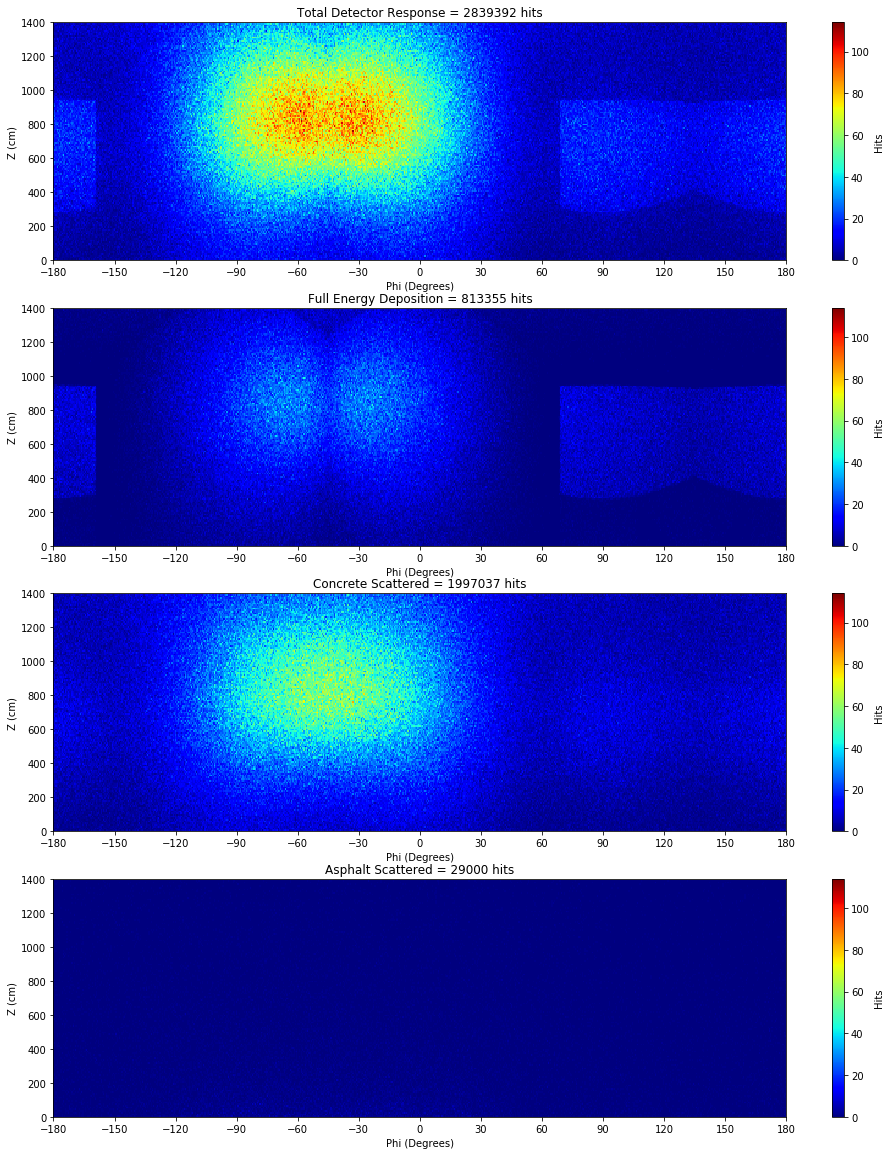

In [10]:
plt.clf()
plt.figure(figsize=(18.8496,8)) 

plt.subplot(411)
plt.imshow(heatmap1.T, extent=extent, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=np.max(heatmap1))
plt.xticks(np.arange(-180., 181., 30.))
plt.ylim(0,1400)
plt.title('Total Detector Response = ' + str(len(Tot)) +' hits')
plt.xlabel('Phi (Degrees)')
plt.ylabel('Z (cm)')
cb = plt.colorbar()
cb.set_label('Hits')
plt.subplot(412)
plt.imshow(heatmap2.T, extent=extent, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=np.max(heatmap1))
plt.xticks(np.arange(-180., 181., 30.))
plt.ylim(0,1400)
plt.title('Full Energy Deposition = ' + str(len(FullE)) +' hits')
plt.xlabel('Phi (Degrees)')
plt.ylabel('Z (cm)')
cb = plt.colorbar()
cb.set_label('Hits')
plt.subplot(413)
plt.imshow(heatmap3.T, extent=extent, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=np.max(heatmap1))
plt.xticks(np.arange(-180., 181., 30.))
plt.ylim(0,1400)
plt.title('Concrete Scattered = ' + str(len(Conc)) +' hits')
plt.xlabel('Phi (Degrees)')
plt.ylabel('Z (cm)')
cb = plt.colorbar()
cb.set_label('Hits')
plt.subplot(414)
plt.imshow(heatmap4.T, extent=extent, aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=np.max(heatmap1))
plt.xticks(np.arange(-180., 181., 30.))
plt.ylim(0,1400)
plt.title('Asphalt Scattered = ' + str(len(Asph)) +' hits')
plt.xlabel('Phi (Degrees)')
plt.ylabel('Z (cm)')
cb = plt.colorbar()
cb.set_label('Hits')

plt.subplots_adjust(bottom=0.1, right=0.8, top=2,)
plt.savefig('images/5Det_Comparison_3fl_wall.png', dpi=800, bbox_inches='tight')
plt.show()


In [11]:
# intersection function
def isect_line_plane_v3(p0, p1, p_co, p_no, epsilon=1e-6):
    """
    p0, p1: define the line - p0 is last point in air/material and p1 is detector interaction point
    p_co, p_no: define the plane:
        p_co is a point on the plane (plane coordinate).
        p_no is a normal vector defining the plane direction;
             (does not need to be normalized).

    return a Vector or None (when the intersection can't be found).
    """

    u = p0-p1
    dot = np.dot(p_no, u)

    if abs(dot) > epsilon:
        # the factor of the point between p0 -> p1 (0 - 1)
        # if 'fac' is between (0 - 1) the point intersects with the segment.
        # otherwise:
        #  < 0.0: behind p0.
        #  > 1.0: infront of p1.
        w = p0-p_co
        fac = -np.dot(p_no, w) / dot
        u = u*fac
        return p0+u
    else:
        # The segment is parallel to plane
        return None

In [12]:
xyz=[250,-250,850]

In [13]:
#Defining Asphault Surface
p1 = np.array([0, -255, 0]) #Bottom Center Point
p2 = np.array([-255, 255, 0]) #Top Left Point
p3 = np.array([255, 255, 0]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [14]:
def inters(surf): #finds where gamma particle departs surface
    intersections = []
    for i in range(len(surf)):
        spoint=np.array([surf[:,4][i], surf[:,5][i], surf[:,6][i]]) #last known point in material
        hpoint=np.array([surf[:,0][i], surf[:,1][i], surf[:,2][i]]) #hit point on detector
        o = isect_line_plane_v3(spoint,hpoint, p1, cp)
        intersections.append(o)
    return intersections

In [15]:
intersections = inters(Asph)

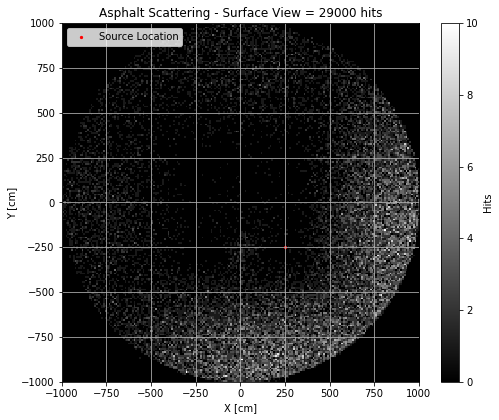

In [16]:
gx,gy,gz = map(list,zip(*intersections))
xedges = np.arange(-1000.0, 1000.1, 10.)
yedges = np.arange(-1000.0, 1000.1, 10.)
AsphTot, _, __ = np.histogram2d(gx,gy, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure(figsize=(8,6.6))
plt.imshow(AsphTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray')
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[1], s=5, c='r',label='Source Location')
plt.title('Asphalt Scattering - Surface View = ' + str(len(Asph)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('images/10Asphalt_Scattered_3fl_wall.png', dpi=800)
plt.show()

In [17]:
#Roof = Tot[(Tot[:,6]>890)] #Creates array of interactions in the Roof - Total Detector Response
North = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the North Wall
South = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the South Wall
East = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the East Wall
West1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the West Wall 
West2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890)] #Creates array of interactions in the West Wall
West = np.vstack((West1,West2))
FullRoof = Tot[(Tot[:,2]==1400) & (Tot[:,3]==Full)] #Creates array of interactions in the Roof - Full Energy Deposition
FullNorth = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the North Wall
FullSouth = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the South Wall
FullEast = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the East Wall
FullWest1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the West Wall 
FullWest2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]==Full)] #Creates array of interactions in the West Wall
FullWest = np.vstack((FullWest1,FullWest2))
PartRoof = Tot[(Tot[:,6]>890) & (Tot[:,3]<Full)] #Creates array of interactions in the Roof - Partial Energy Deposition
PartNorth = Tot[(Tot[:,7]<135) & (Tot[:,7]>45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the North Wall
PartSouth = Tot[(Tot[:,7]<-45) & (Tot[:,7]>-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the South Wall
PartEast = Tot[(Tot[:,7]<45) & (Tot[:,7]>-45) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the East Wall
PartWest1 = Tot[(Tot[:,7]<-135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the West Wall 
PartWest2 = Tot[(Tot[:,7]>135) & (Tot[:,6]>0) & (Tot[:,6]<890) & (Tot[:,3]<Full)] #Creates array of interactions in the West Wall
PartWest = np.vstack((PartWest1,PartWest2))
Roof = np.vstack((FullRoof,PartRoof))

In [18]:
np.shape(FullRoof)

(260475, 8)

In [19]:
np.shape(PartRoof)

(726746, 8)

In [20]:
np.shape(Roof)

(987221, 8)

In [21]:
#Defining Roof Surface
p1 = np.array([0, -255, 900]) #Bottom Center Point
p2 = np.array([-255, 255, 900]) #Top Left Point
p3 = np.array([255, 255, 900]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [22]:
intersections = inters(Roof)

In [23]:
rx,ry,rz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(-310.0, 310.1, 10.)
RoofTot, _, __ = np.histogram2d(rx,ry, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [24]:
intersections = inters(FullRoof)

In [25]:
rx,ry,rz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(-310.0, 310.1, 10.)
RoofFull, _, __ = np.histogram2d(rx,ry, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [26]:
intersections = inters(PartRoof)

In [27]:
rx,ry,rz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(-310.0, 310.1, 10.)
RoofPart, _, __ = np.histogram2d(rx,ry, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


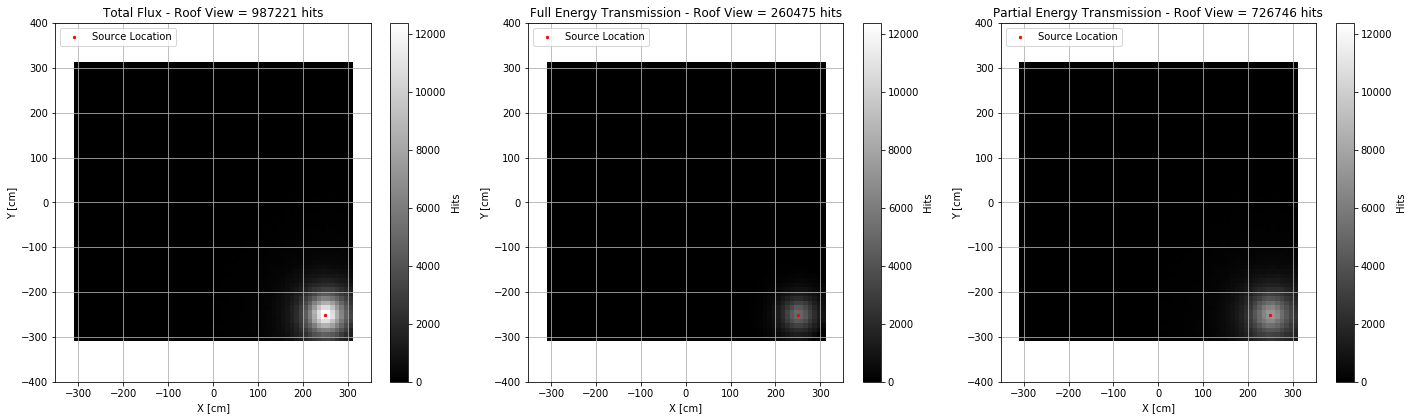

In [28]:
plt.clf()
plt.figure(figsize=(24,6.6)) 

plt.subplot(131)
plt.imshow(RoofTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(RoofTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[1], s=5, c='r',label='Source Location')
plt.title('Total Flux - Roof View = ' + str(len(Roof)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.axis('equal')
plt.axis([-400, 400, -400, 400])
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(132)
plt.imshow(RoofFull.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(RoofTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[1], s=5, c='r',label='Source Location')
plt.title('Full Energy Transmission - Roof View = ' + str(len(FullRoof)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.axis('equal')
plt.axis([-400, 400, -400, 400])
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(133)
plt.imshow(RoofPart.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(RoofTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[1], s=5, c='r',label='Source Location')
plt.title('Partial Energy Transmission - Roof View = ' + str(len(PartRoof)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.axis('equal')
plt.axis([-400, 400, -400, 400])
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('images/11Flux_Roof_Comparison_3fl_wall.png', dpi=800)
plt.show()

In [29]:
#Defining North Wall Surface
p1 = np.array([0, 310, 0]) #Bottom Center Point
p2 = np.array([-255, 310, 1000]) #Top Left Point
p3 = np.array([255, 310, 1000]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [30]:
intersections = inters(North)

In [31]:
tnx,tny,tnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthTot, _, __ = np.histogram2d(tnx,tnz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [32]:
intersections = inters(FullNorth)

In [33]:
fnx,fny,fnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthFull, _, __ = np.histogram2d(fnx,fnz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [34]:
intersections = inters(PartNorth)

In [35]:
pnx,pny,pnz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
NorthPart, _, __ = np.histogram2d(pnx,pnz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


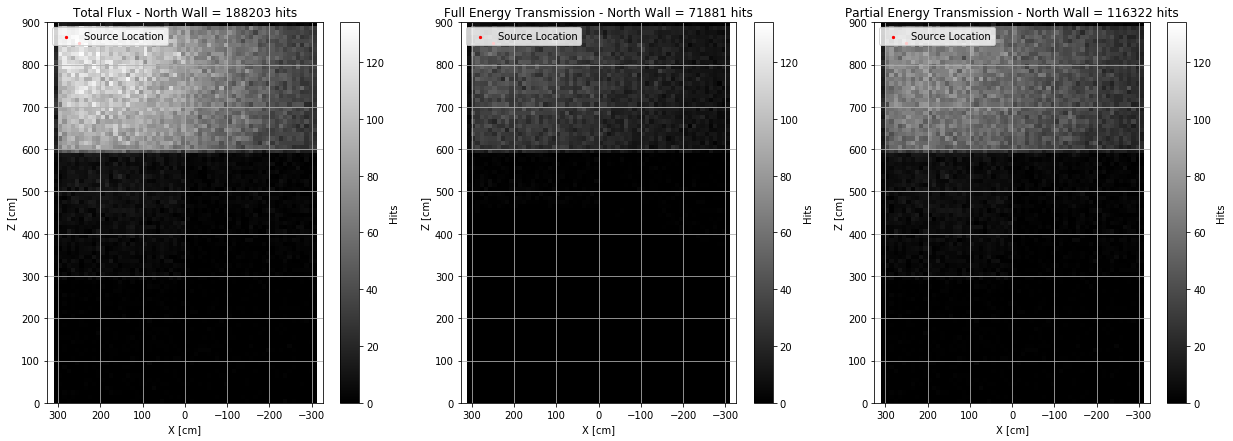

In [36]:
plt.clf()
plt.figure(figsize=(21,7)) 

plt.subplot(131)
plt.imshow(NorthTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(NorthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Total Flux - North Wall = ' + str(len(North)) +' hits')
plt.xlim(300,-300)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(132)
plt.imshow(NorthFull.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(NorthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Full Energy Transmission - North Wall = ' + str(len(FullNorth)) +' hits')
plt.xlim(300,-300)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(133)
plt.imshow(NorthPart.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(NorthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Partial Energy Transmission - North Wall = ' + str(len(PartNorth)) +' hits')
plt.xlim(300,-300)
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('images/12Flux_North_Comparison_3fl_wall.png', dpi=800)
plt.show()

In [37]:
#Defining South Wall Surface
p1 = np.array([0, -310, 0]) #Bottom Center Point
p2 = np.array([-255, -310, 1000]) #Top Left Point
p3 = np.array([255, -310, 1000]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [38]:
intersections = inters(South)

In [39]:
tsx,tsy,tsz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
SouthTot, _, __ = np.histogram2d(tsx,tsz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [40]:
intersections = inters(FullSouth)

In [41]:
fsx,fsy,fsz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
SouthFull, _, __ = np.histogram2d(fsx,fsz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [42]:
intersections = inters(PartSouth)

In [43]:
psx,psy,psz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
SouthPart, _, __ = np.histogram2d(psx,psz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


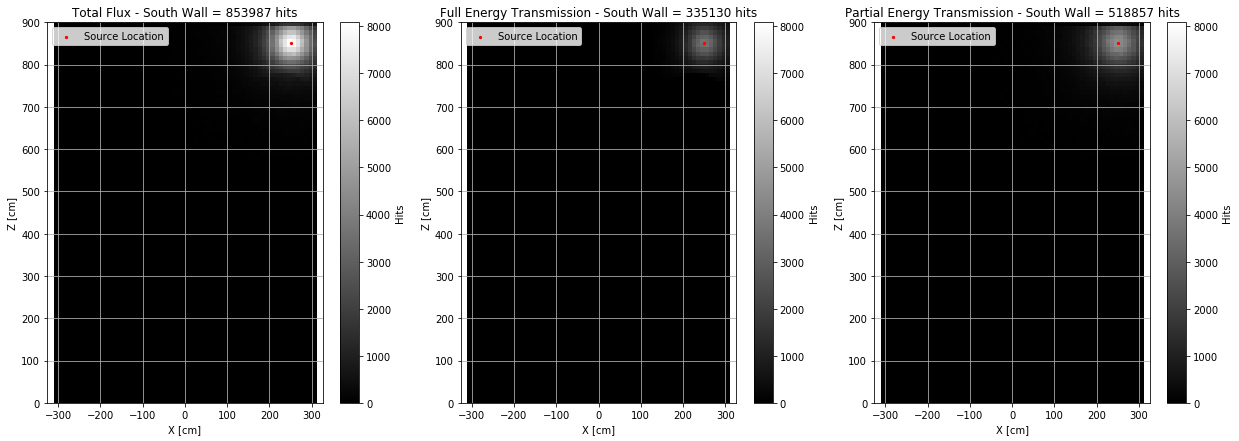

In [44]:
plt.clf()
plt.figure(figsize=(21,7)) 

plt.subplot(131)
plt.imshow(SouthTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(SouthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Total Flux - South Wall = ' + str(len(South)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(132)
plt.imshow(SouthFull.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(SouthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Full Energy Transmission - South Wall = ' + str(len(FullSouth)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(133)
plt.imshow(SouthPart.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(SouthTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[0], xyz[2], s=5, c='r',label='Source Location')
plt.title('Partial Energy Transmission - South Wall = ' + str(len(PartSouth)) +' hits')
plt.xlabel('X [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('images/13Flux_South_Comparison_3fl_wall.png', dpi=800)
plt.show()

In [45]:
#Defining East Wall Surface
p1 = np.array([310, 0, 0]) #Bottom Center Point
p2 = np.array([310, 255, 1000]) #Top Left Point
p3 = np.array([310, -255, 1000]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [46]:
intersections = inters(East)

In [47]:
tex,tey,tez = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
EastTot, _, __ = np.histogram2d(tey,tez, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [48]:
intersections = inters(FullEast)

In [49]:
fex,fey,fez = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
EastFull, _, __ = np.histogram2d(fey,fez, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [50]:
intersections = inters(PartEast)

In [51]:
pex,pey,pez = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
EastPart, _, __ = np.histogram2d(pey,pez, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


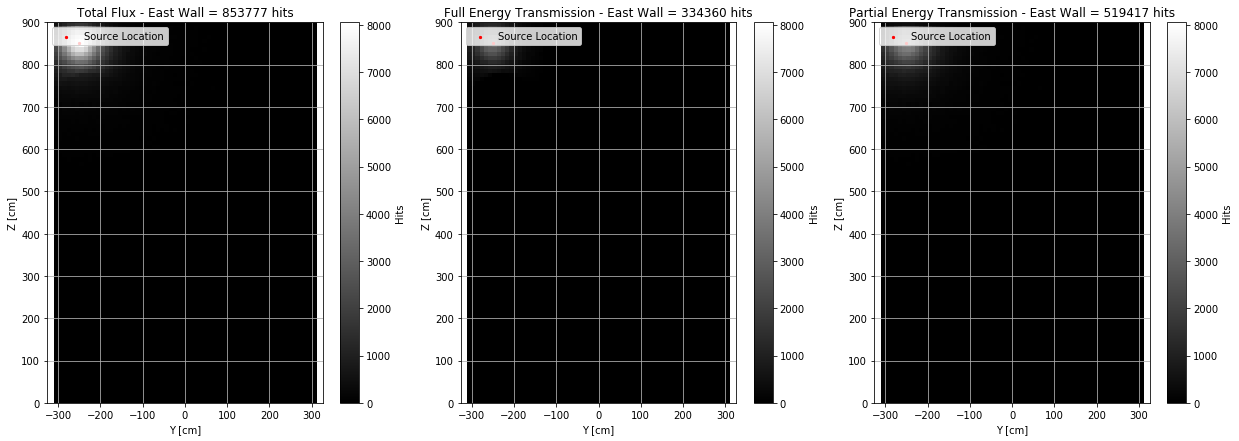

In [52]:
plt.clf()
plt.figure(figsize=(21,7)) 

plt.subplot(131)
plt.imshow(EastTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(EastTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Total Flux - East Wall = ' + str(len(East)) +' hits')
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(132)
plt.imshow(EastFull.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(EastTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Full Energy Transmission - East Wall = ' + str(len(FullEast)) +' hits')
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(133)
plt.imshow(EastPart.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(EastTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Partial Energy Transmission - East Wall = ' + str(len(PartEast)) +' hits')
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('images/14Flux_East_Comparison_3fl_wall.png', dpi=800)
plt.show()

In [53]:
#Defining West Wall Surface
p1 = np.array([-310, 0, 0]) #Bottom Center Point
p2 = np.array([-310, -255, 1000]) #Top Left Point
p3 = np.array([-310, 255, 1000]) #Top Right Point
# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1
# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

In [54]:
intersections = inters(West)

In [55]:
twx,twy,twz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
WestTot, _, __ = np.histogram2d(twy,twz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [56]:
intersections = inters(FullWest)

In [57]:
fwx,fwy,fwz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
WestFull, _, __ = np.histogram2d(fwy,fwz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


In [58]:
intersections = inters(PartWest)

In [59]:
pwx,pwy,pwz = map(list,zip(*intersections))
xedges = np.arange(-310.0, 310.1, 10.)
yedges = np.arange(0.0, 900.1, 10.)
WestPart, _, __ = np.histogram2d(pwy,pwz, bins=[xedges, yedges])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


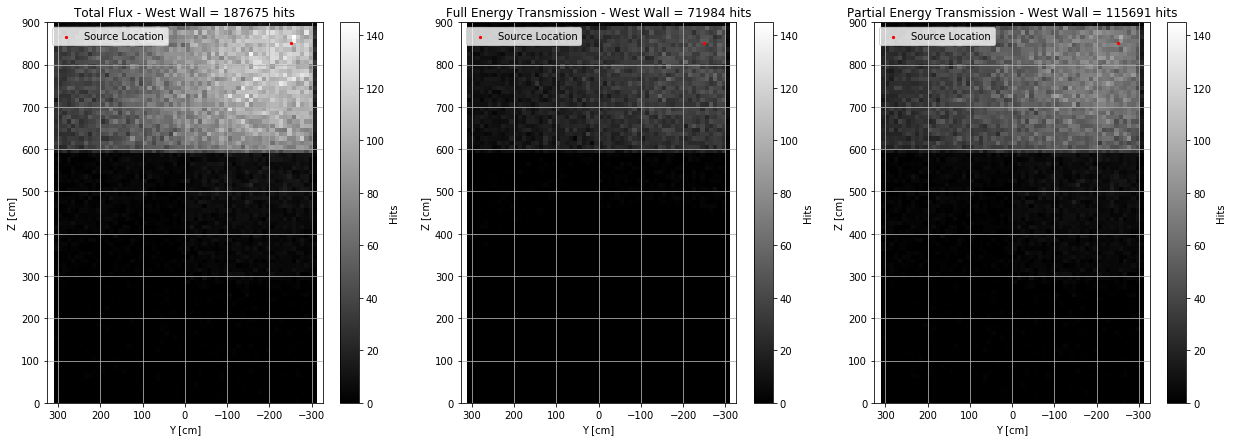

In [60]:
plt.clf()
plt.figure(figsize=(21,7)) 

plt.subplot(131)
plt.imshow(WestTot.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(WestTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Total Flux - West Wall = ' + str(len(West)) +' hits')
plt.xlim(300,-300)
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(132)
plt.imshow(WestFull.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(WestTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Full Energy Transmission - West Wall = ' + str(len(FullWest)) +' hits')
plt.xlim(300,-300)
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(133)
plt.imshow(WestPart.T, extent=extent, aspect='auto', origin='lower', cmap='gray', vmin=0, vmax=np.max(WestTot))
cb = plt.colorbar()
cb.set_label('Hits')
plt.scatter(xyz[1], xyz[2], s=5, c='r',label='Source Location')
plt.title('Partial Energy Transmission - West Wall = ' + str(len(PartWest)) +' hits')
plt.xlim(300,-300)
plt.xlabel('Y [cm]')
plt.ylabel('Z [cm]')
plt.axis('equal')
plt.grid(True)
plt.legend(loc='upper left')

plt.savefig('images/15Flux_West_Comparison_3fl_wall.png', dpi=800)
plt.show()

In [61]:
np.max(EastTot.T)

8053.0

In [62]:
np.max(SouthTot.T)

8084.0

In [63]:
np.max(WestTot.T)

145.0

In [64]:
np.max(NorthTot.T)

134.0

In [65]:
np.max(AsphTot.T)

10.0

In [66]:
np.max(RoofTot.T)

12373.0

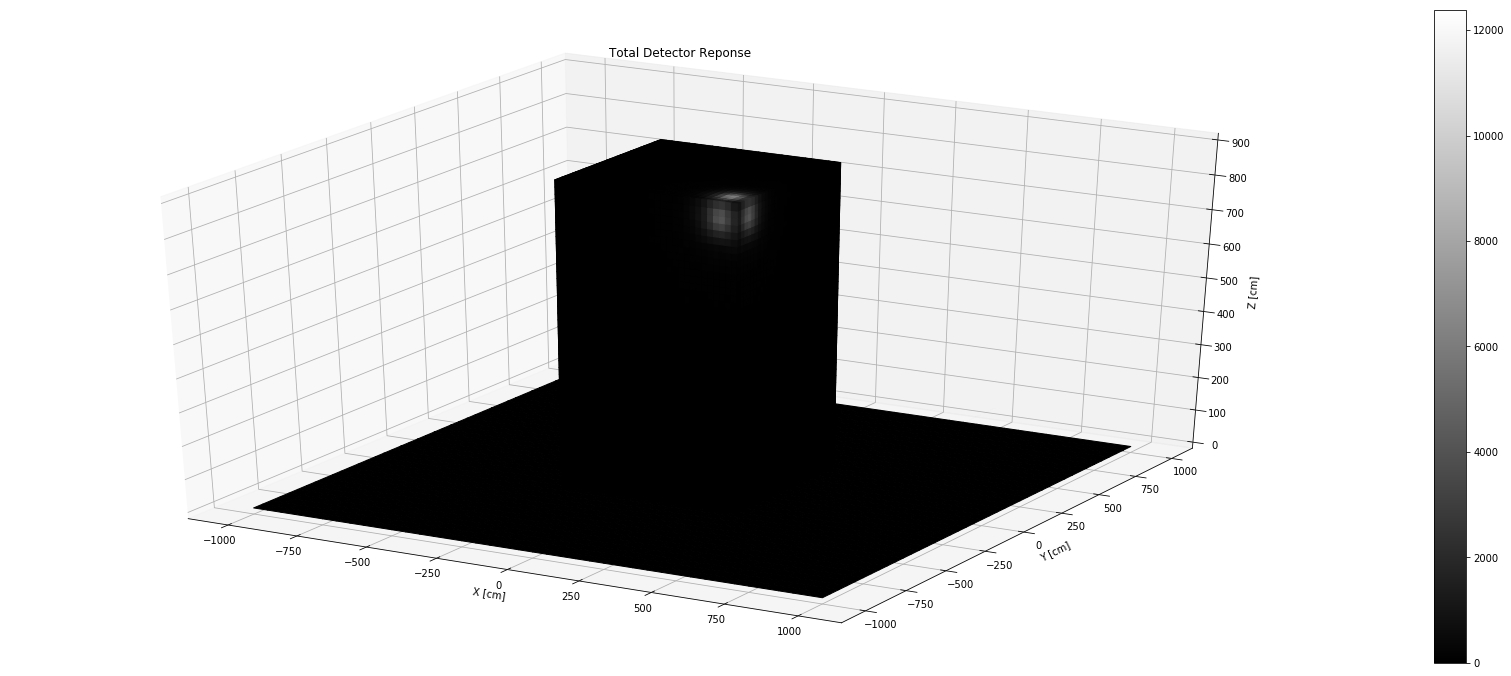

In [67]:
# Create mesh for ground.
GX = np.arange(-1000, 1000.1, 10)
GY = np.arange(-1000, 1000.1, 10)
GX, GY = np.meshgrid(GX, GY)

# Create mesh for roof.
RX = np.arange(-310, 310.1, 10)
RY = np.arange(-310, 310.1, 10)
RX, RY = np.meshgrid(RX, RY)

# Create mesh for walls.
VZ = np.arange(0, 900.1, 10)
VY = np.arange(-310, 310.1, 10)
VY, VZ = np.meshgrid(VY, VZ)
HZ = np.arange(0, 900.1, 10)
HX = np.arange(-310, 310.1, 10)
HX, HZ = np.meshgrid(HX, HZ)

# Create flat surfaces.
GZ = np.zeros_like(GX)
RZ = np.zeros_like(RX)
VX = np.zeros_like(VZ) #Vertical Surface
HY = np.zeros_like(HZ) #Horizontal Surface

# Normalize data for colormap use.
A = np.copy(AsphTot.T)
B = np.copy(RoofTot.T)
C = np.copy(EastTot.T)
D = np.copy(WestTot.T)
E = np.copy(NorthTot.T)
F = np.copy(SouthTot.T)


# Normalize data for colormap use to highest plane
A -= 0; A /= np.max(RoofTot.T);
B -= 0; B /= np.max(RoofTot.T);
C -= 0; C /= np.max(RoofTot.T);
D -= 0; D /= np.max(RoofTot.T);
E -= 0; E /= np.max(RoofTot.T);
F -= 0; F /= np.max(RoofTot.T);


fig = plt.figure(figsize=(30,12))
ax = fig.gca(projection='3d')
ax.plot_surface(GX, GY, GZ, facecolors = cm.gray(A))
ax.plot_surface(RX, RY, RZ+900, facecolors = cm.gray(B))
ax.plot_surface(VX+310, VY, VZ, facecolors = cm.gray(C))
ax.plot_surface(VX-310, VY, VZ, facecolors = cm.gray(D))
ax.plot_surface(HX, HY+310, HZ, facecolors = cm.gray(E))
ax.plot_surface(HX, HY-310, HZ, facecolors = cm.gray(F))
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
plt.title('Total Detector Reponse')

m = cm.ScalarMappable(cmap=cm.gray)
m.set_array(F)
m.set_clim(0, np.max(RoofTot.T))
plt.colorbar(m)
plt.savefig('images/17_3D_Flux_Tot_3fl_wall.png', dpi=800)
plt.show()

def rotate(angle):
    ax.view_init(60, azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(-90, 272, 2), interval=100)
rot_animation.save('images/16_3D_Flux_Tot_3fl_wall.mp4')

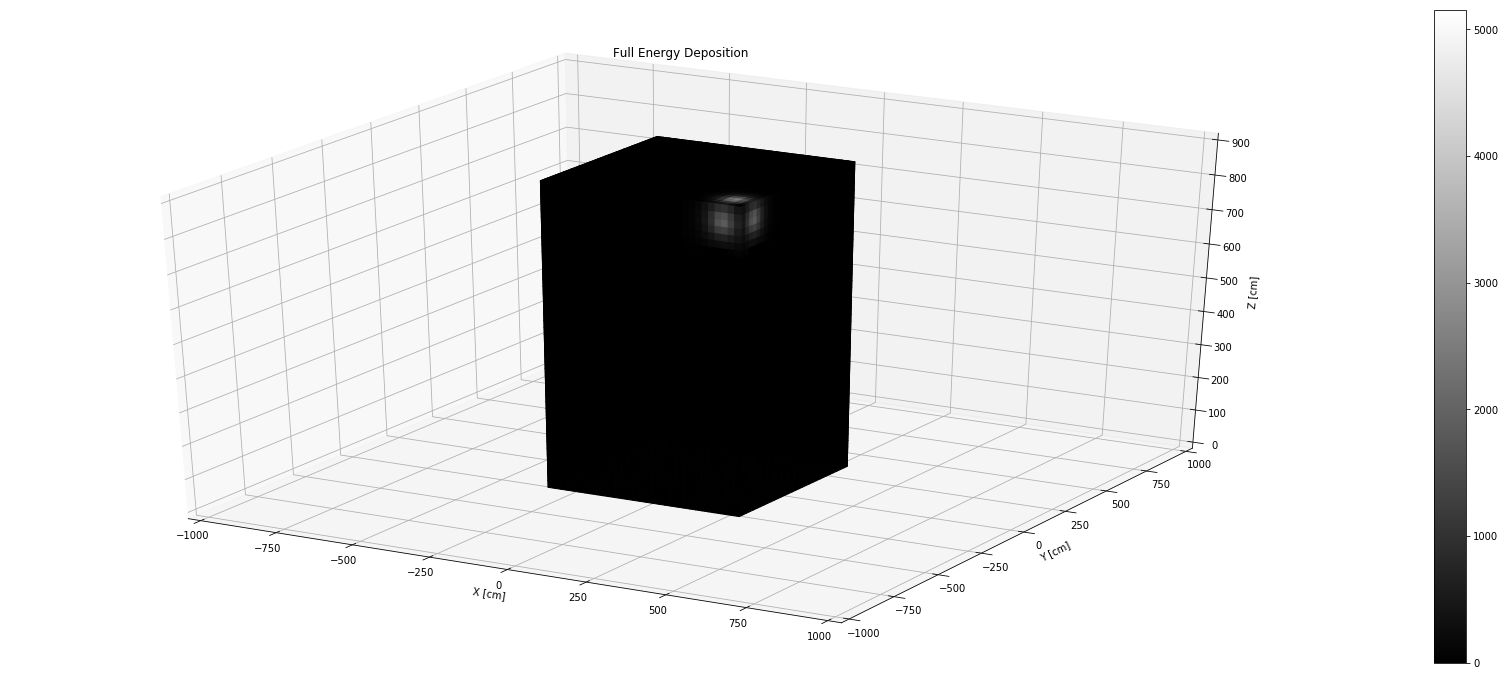

In [68]:
# Create mesh for ground.
GX = np.arange(-1000, 1000.1, 10)
GY = np.arange(-1000, 1000.1, 10)
GX, GY = np.meshgrid(GX, GY)

# Create mesh for roof.
RX = np.arange(-310, 310.1, 10)
RY = np.arange(-310, 310.1, 10)
RX, RY = np.meshgrid(RX, RY)

# Create mesh for walls.
VZ = np.arange(0, 900.1, 10)
VY = np.arange(-310, 310.1, 10)
VY, VZ = np.meshgrid(VY, VZ)
HZ = np.arange(0, 900.1, 10)
HX = np.arange(-310, 310.1, 10)
HX, HZ = np.meshgrid(HX, HZ)

# Create flat surfaces.
GZ = np.zeros_like(GX)
RZ = np.zeros_like(RX)
VX = np.zeros_like(VZ) #Vertical Surface
HY = np.zeros_like(HZ) #Horizontal Surface

# Normalize data for colormap use.
#A = np.copy(AsphTot.T)
B = np.copy(RoofFull.T)
C = np.copy(EastFull.T)
D = np.copy(WestFull.T)
E = np.copy(NorthFull.T)
F = np.copy(SouthFull.T)


# Normalize data for colormap use to highest plane
#A -= 0; A /= np.max(SouthTot.T);
B -= 0; B /= np.max(RoofFull.T);
C -= 0; C /= np.max(RoofFull.T);
D -= 0; D /= np.max(RoofFull.T);
E -= 0; E /= np.max(RoofFull.T);
F -= 0; F /= np.max(RoofFull.T);


fig = plt.figure(figsize=(30,12))
ax = fig.gca(projection='3d')
#ax.plot_surface(GX, GY, GZ, facecolors = cm.gray(A))
ax.plot_surface(RX, RY, RZ+900, facecolors = cm.gray(B))
ax.plot_surface(VX+310, VY, VZ, facecolors = cm.gray(C))
ax.plot_surface(VX-310, VY, VZ, facecolors = cm.gray(D))
ax.plot_surface(HX, HY+310, HZ, facecolors = cm.gray(E))
ax.plot_surface(HX, HY-310, HZ, facecolors = cm.gray(F))
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim3d(-1000,1000)
ax.set_ylim3d(-1000,1000)
ax.set_zlim3d(0,900)
plt.title('Full Energy Deposition')

m = cm.ScalarMappable(cmap=cm.gray)
m.set_array(F)
m.set_clim(0, np.max(RoofFull.T))
plt.colorbar(m)
plt.savefig('images/17_3D_Flux_Full_3fl_wall.png', dpi=800)
plt.show()

def rotate(angle):
    ax.view_init(60, azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(-90, 272, 2), interval=100)
rot_animation.save('images/16_3D_Flux_Full_3fl_wall.mp4')

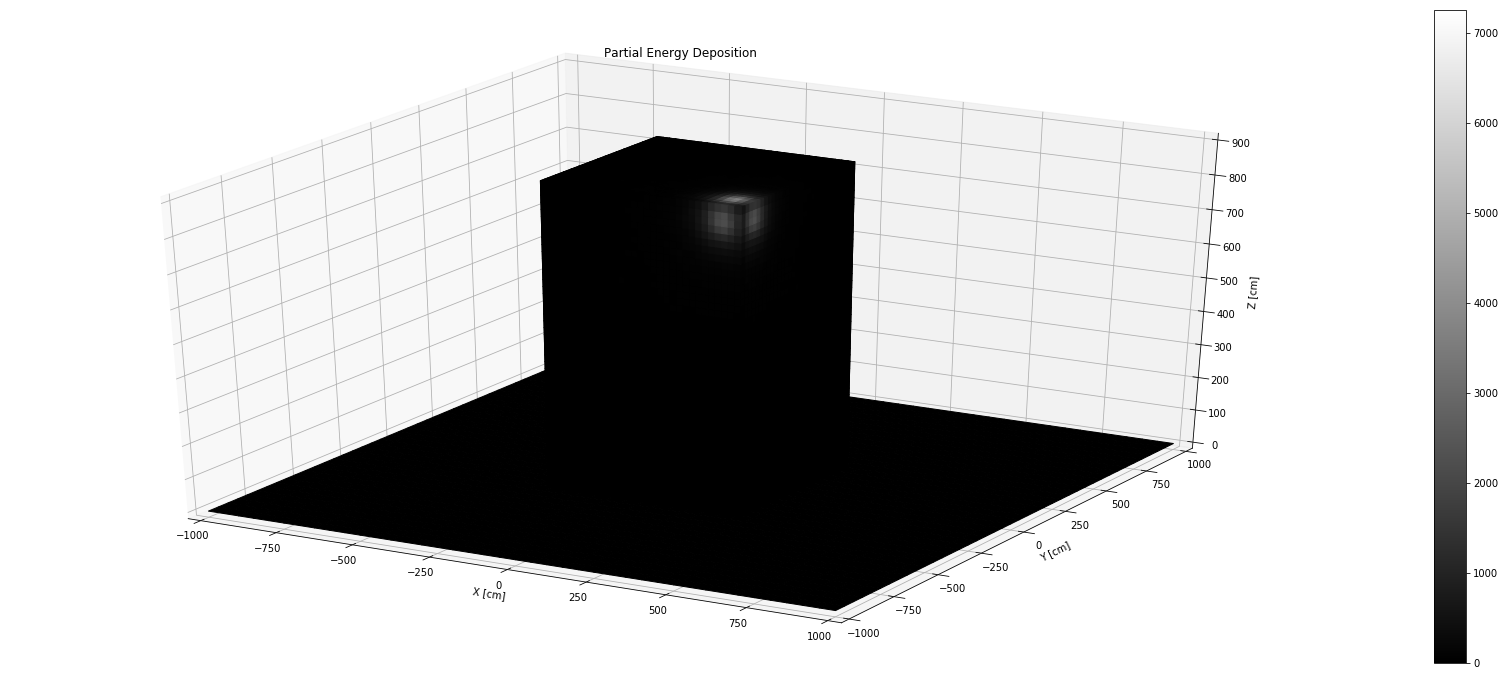

In [69]:
# Create mesh for ground.
GX = np.arange(-1000, 1000.1, 10)
GY = np.arange(-1000, 1000.1, 10)
GX, GY = np.meshgrid(GX, GY)

# Create mesh for roof.
RX = np.arange(-310, 310.1, 10)
RY = np.arange(-310, 310.1, 10)
RX, RY = np.meshgrid(RX, RY)

# Create mesh for walls.
VZ = np.arange(0, 900.1, 10)
VY = np.arange(-310, 310.1, 10)
VY, VZ = np.meshgrid(VY, VZ)
HZ = np.arange(0, 900.1, 10)
HX = np.arange(-310, 310.1, 10)
HX, HZ = np.meshgrid(HX, HZ)

# Create flat surfaces.
GZ = np.zeros_like(GX)
RZ = np.zeros_like(RX)
VX = np.zeros_like(VZ) #Vertical Surface
HY = np.zeros_like(HZ) #Horizontal Surface

# Normalize data for colormap use.
A = np.copy(AsphTot.T)
B = np.copy(RoofPart.T)
C = np.copy(EastPart.T)
D = np.copy(WestPart.T)
E = np.copy(NorthPart.T)
F = np.copy(SouthPart.T)


# Normalize data for colormap use to highest plane
A -= 0; A /= np.max(RoofPart.T);
B -= 0; B /= np.max(RoofPart.T);
C -= 0; C /= np.max(RoofPart.T);
D -= 0; D /= np.max(RoofPart.T);
E -= 0; E /= np.max(RoofPart.T);
F -= 0; F /= np.max(RoofPart.T);


fig = plt.figure(figsize=(30,12))
ax = fig.gca(projection='3d')
ax.plot_surface(GX, GY, GZ, facecolors = cm.gray(A))
ax.plot_surface(RX, RY, RZ+900, facecolors = cm.gray(B))
ax.plot_surface(VX+310, VY, VZ, facecolors = cm.gray(C))
ax.plot_surface(VX-310, VY, VZ, facecolors = cm.gray(D))
ax.plot_surface(HX, HY+310, HZ, facecolors = cm.gray(E))
ax.plot_surface(HX, HY-310, HZ, facecolors = cm.gray(F))
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim3d(-1000,1000)
ax.set_ylim3d(-1000,1000)
ax.set_zlim3d(0,900)
plt.title('Partial Energy Deposition')

m = cm.ScalarMappable(cmap=cm.gray)
m.set_array(F)
m.set_clim(0, np.max(RoofPart.T))
plt.colorbar(m)
plt.savefig('images/17_3D_Flux_Part_3fl_wall.png', dpi=800)
plt.show()

def rotate(angle):
    ax.view_init(60, azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(-90, 272, 2), interval=100)
rot_animation.save('images/16_3D_Flux_Part_3fl_wall.mp4')